In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

/home/k3v1n/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading and merging the datasets
df_amazon = pd.read_csv("amazon_cells_labelled.txt", sep="\t")
df_imdb = pd.read_csv("imdb_labelled.txt", sep="\t")
df_yelp = pd.read_csv("yelp_labelled.txt", sep="\t")
df_reviews = pd.concat([df_amazon, df_imdb, df_yelp])
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)
df_reviews

,reviews,sentiment
0,I'm very disappointed with my decision.,0
1,Couldn't figure it out,0
2,This allows the possibility of double booking ...,0
3,I liked this movie way too much.,1
4,"The results, well, are a shame.",0
...,...,...
2743,"I loved it, it was really scary.",1
2744,And it was way to expensive.,0
2745,But this movie is definitely a below average r...,0
2746,Thoroughly disappointed!,0


In [3]:
reviews = df_reviews["reviews"].values
sentiments = df_reviews["sentiment"].values

In [4]:
# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    reviews, sentiments, test_size=0.2, random_state=42
)

In [5]:
# Load the pre-trained BERT tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [6]:
# Tokenize the data
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

In [7]:
train_encodings = tokenize(train_texts, tokenizer)
val_encodings = tokenize(val_texts, tokenizer)

In [8]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)


In [9]:
# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

In [10]:
from transformers import AutoModelForSequenceClassification

# Load BERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2  # Binary classification
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler

# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Training loop
epochs = 3
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())
    
    # Average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(batch["labels"].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    val_accuracy_history.append(accuracy)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1


  0%|          | 0/138 [00:00<?, ?it/s]/tmp/ipykernel_18673/3415262602.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 138/138 [00:41<00:00,  3.33it/s, loss=0.274] 


Training Loss: 0.2789, Validation Loss: 0.2287, Validation Accuracy: 0.9055
Epoch 2


  0%|          | 0/138 [00:00<?, ?it/s]/tmp/ipykernel_18673/3415262602.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 138/138 [00:43<00:00,  3.21it/s, loss=0.0531] 


Training Loss: 0.0825, Validation Loss: 0.2028, Validation Accuracy: 0.9345
Epoch 3


  0%|          | 0/138 [00:00<?, ?it/s]/tmp/ipykernel_18673/3415262602.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████| 138/138 [00:49<00:00,  2.80it/s, loss=0.00348]


Training Loss: 0.0340, Validation Loss: 0.2608, Validation Accuracy: 0.9218


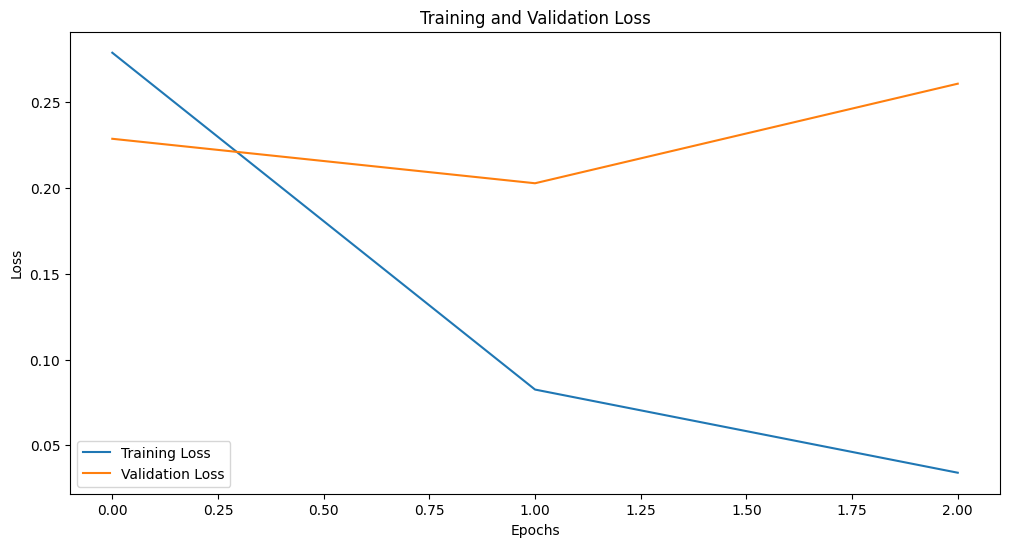

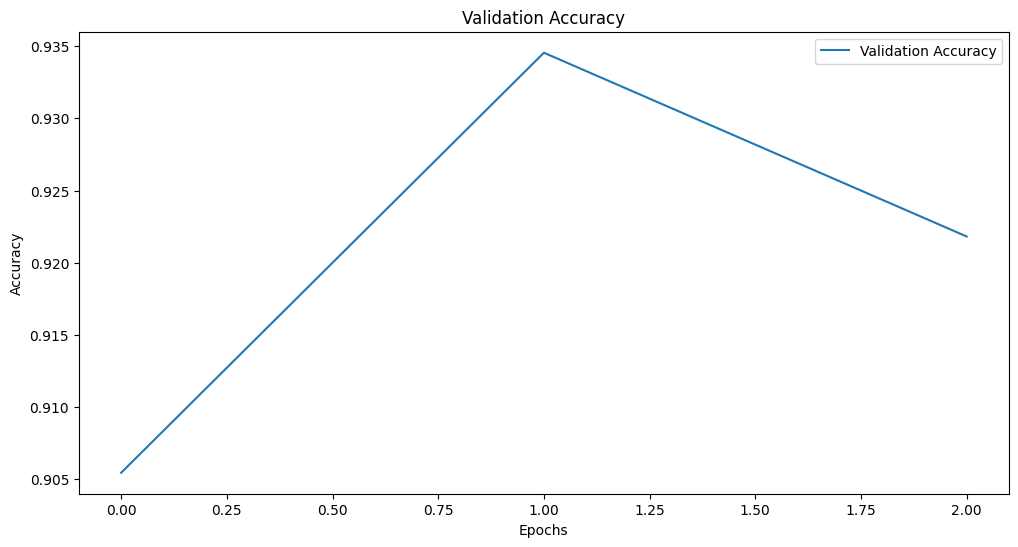

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate model on validation data
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_labels.extend(batch["labels"].cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

/tmp/ipykernel_18673/3415262602.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.89      0.92       275
    Positive       0.89      0.96      0.92       275

    accuracy                           0.92       550
   macro avg       0.92      0.92      0.92       550
weighted avg       0.92      0.92      0.92       550

Confusion Matrix:
 [[244  31]
 [ 12 263]]


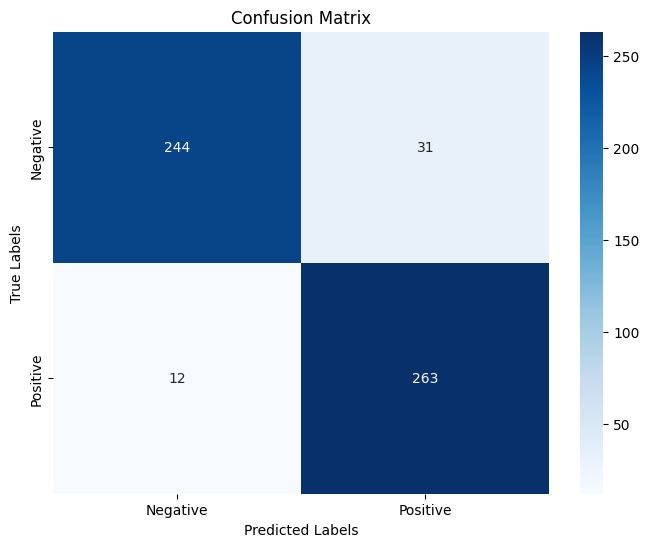

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [16]:
model.save_pretrained("./bert_sentiment_model")
tokenizer.save_pretrained("./bert_sentiment_model")
print("Model Saved")

Model Saved
